The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


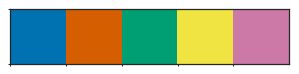

In [18]:
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_venn as vn
from scipy import stats
import seaborn as sns
from rpy2 import robjects as robj

#load r magics
%load_ext rpy2.ipython
#auto converts pulled R dataframes into pandas dataframes!
robj.pandas2ri.activate()

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=2, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [19]:
pd.__version__

'0.20.3'

In [20]:
%%bash

g4predict intra \
  -f /home/matthew/Documents/genomes/tair10/fasta/tair10_genome.fa \
  -b /tmp/tair10_g4.bed \
  -s \
  -F \
  -tmin 2 \
  -tmax 2 \
  -lmin 1 \
  -lmax 7

INFO:root:Output from G4Predict
INFO:root:Parsing command line arguments
INFO:root:Running in mode: intra
INFO:root:Parameters:
{       'bed': '/tmp/tair10_g4.bed',
        'fasta': '/home/matthew/Documents/genomes/tair10/fasta/tair10_genome.fa',
        'filter_overlapping': True,
        'func': <function parse_args.<locals>.intra at 0x7fa423e99f28>,
        'merge_overlapping': False,
        'write_bed12': False,
        'write_bed6': True}
INFO:root:G4 Parameters: 
{       'bulge_kwargs': {'bulges_allowed': 0, 'start': 1, 'stop': 5},
        'inter_kwargs': {'start': 2, 'stop': 3},
        'loop_kwargs_list': [       {'allow_G': 1, 'start': 1, 'stop': 7},
                                    {'allow_G': 1, 'start': 1, 'stop': 7},
                                    {'allow_G': 1, 'start': 1, 'stop': 7}],
        'score_kwargs': {       'bulge_pen_factor': 5,
                                'loop_pen_factor': 1.5,
                                'tetrad_score_factor': 20},
        '

In [21]:
%%bash
source activate jupyter_python3

bedtools makewindows \
  -g /home/matthew/Documents/genomes/tair10/tair10.chrom.sizes \
  -w 200 -s 25 -i srcwinnum | tee >(\
    awk -v OFS="\t" '{print $0 "_pos", ".", "+"}'  > /tmp/windows_pos.bed) | \
    awk -v OFS="\t" '{print $0 "_neg", ".", "-"}'  > /tmp/windows_neg.bed
cat /tmp/windows_pos.bed /tmp/windows_neg.bed | \
sort -k1,1 -k2,2n > /tmp/windows.bed

In [22]:
!head /tmp/windows.bed

1	0	200	1_1_neg	.	-
1	0	200	1_1_pos	.	+
1	25	225	1_2_neg	.	-
1	25	225	1_2_pos	.	+
1	50	250	1_3_neg	.	-
1	50	250	1_3_pos	.	+
1	75	275	1_4_neg	.	-
1	75	275	1_4_pos	.	+
1	100	300	1_5_neg	.	-
1	100	300	1_5_pos	.	+


In [23]:
%%bash
source activate jupyter_python3

bedtools map -c 4 -o count -s \
  -a /tmp/windows.bed \
  -b /tmp/tair10_g4.bed | \
awk -v OFS="\t" '{print $1, $2, $3, $4, $7, $6}' \
  > /tmp/g4_windowed_counts.bed

In [24]:
!head /tmp/g4_windowed_counts.bed

1	0	200	1_1_neg	3	-
1	0	200	1_1_pos	0	+
1	25	225	1_2_neg	2	-
1	25	225	1_2_pos	0	+
1	50	250	1_3_neg	2	-
1	50	250	1_3_pos	0	+
1	75	275	1_4_neg	1	-
1	75	275	1_4_pos	0	+
1	100	300	1_5_neg	1	-
1	100	300	1_5_pos	0	+


In [25]:
%%bash
source activate jupyter_python3

bedtools map -c 5 -o max -s -prec 1 -F 0.75 \
  -a /home/matthew/Documents/genomes/tair10/gff/araport11_genes.bed \
  -b /tmp/g4_windowed_counts.bed > /tmp/g4_pos_maximal_density.bed

bedtools map -c 5 -o max -S -prec 1 -F 0.75 \
  -a /home/matthew/Documents/genomes/tair10/gff/araport11_genes.bed \
  -b /tmp/g4_windowed_counts.bed > /tmp/g4_neg_maximal_density.bed

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

colnames = ['chrom', 'start', 'end', 'gene_id', 'score', 'strand', 'max_g4_density']
converters = {'gene_id': str,
              'max_g4_density': lambda x: 0 if x == '.' else round(float(x))}
pos_g4_density = pd.read_csv('/tmp/g4_pos_maximal_density.bed',
                             sep='\t',
                             names=colnames,
                             converters=converters,
                             usecols=['gene_id', 'max_g4_density'])
neg_g4_density = pd.read_csv('/tmp/g4_neg_maximal_density.bed',
                             sep='\t',
                             names=colnames,
                             converters=converters,
                             usecols=['gene_id', 'max_g4_density'])
neg_g4_density['max_g4_density'] = neg_g4_density.max_g4_density.astype('i')

g4_max_density = pos_g4_density.merge(neg_g4_density,
                                      on='gene_id',
                                      suffixes=('_coding', '_template'))
g4_max_density.head()                                    

,gene_id,max_g4_density_coding,max_g4_density_template
0,AT1G01010,1,1
1,AT1G01020,0,0
2,AT1G03987,0,0
3,AT1G01030,0,1
4,AT1G01040,1,1


In [27]:
%%R -o nmm

library(oligo)
library(puma)

load('/home/matthew/Documents/analysis_notebooks/tair10_nmm_6h_24h/data/puma_objects.rdata')
e <- exprs(combined)
p <- statistic(pplrs)
f <- as(getNetAffx(normalised, 'transcript'), 'data.frame')[c(9, 18)]
nmm <- merge(f, merge(e, p, by=0), by.x=0, by.y='Row.names')
nmm <- nmm[nmm['category'] == 'main',]
nmm['logFC_NMM_6h_vs_DMSO_6h'] <- nmm['NMM_6h'] - nmm['DMSO_6h']
nmm['logFC_NMM_24h_vs_DMSO_24h'] <- nmm['NMM_24h'] - nmm['DMSO_24h']
nmm['logFC_NMM_24h_vs_NMM_6h'] <- nmm['NMM_24h'] - nmm['NMM_6h']
nmm['PPLR_NMM_6h_vs_DMSO_6h'] <- nmm['2_vs_1']
nmm['PPLR_NMM_24h_vs_DMSO_24h'] <- nmm['4_vs_3']
nmm['PPLR_NMM_24h_vs_NMM_6h'] <- nmm['4_vs_2']

/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: BiocGenerics

  warnings.warn(x, RRuntimeWarning)
/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)
/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘BiocGenerics’


  warnings.warn(x, RRuntimeWarning)
/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


  warnings.warn(x, RRuntimeWarning)
/home/matthew/anaconda3/envs/ml

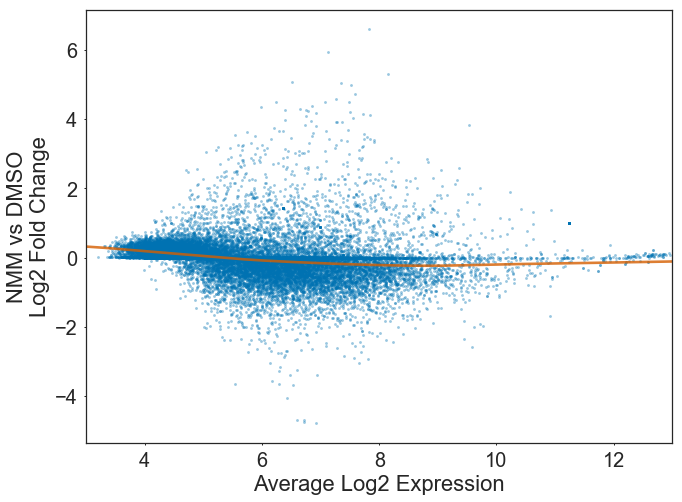

In [28]:
nmm['Av_Exprs'] = nmm[['NMM_6h', 'DMSO_6h']].mean(1)
fig, ax = plt.subplots(figsize=(10, 7.5))
sns.regplot(x='Av_Exprs',
            y='logFC_NMM_6h_vs_DMSO_6h',
            data=nmm,
            scatter_kws={'alpha': 0.4, 'color': pal[0],
                         's': 8, 'rasterized': True},
            line_kws={'color': pal[1], 'alpha': 0.8},
            lowess=True,
            ax=ax)
ax.set_xlim(3, 13)
ax.set_xlabel('Average Log2 Expression')
ax.set_ylabel('NMM vs DMSO\nLog2 Fold Change')
plt.tight_layout()
plt.savefig('NMM_DMSO_MA_plot.svg')
plt.show()

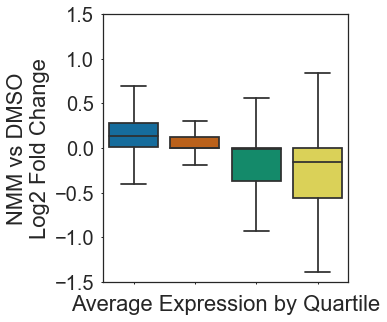

In [29]:
nmm['av_exprs_quartiles'] = pd.qcut(nmm.Av_Exprs, 4)
fig, ax = plt.subplots(figsize=(5.5, 5))
sns.boxplot(x='av_exprs_quartiles', y='logFC_NMM_6h_vs_DMSO_6h', data=nmm, fliersize=0)
ax.set_ylim(-1.5, 1.5)
ax.set_xticklabels(['', '', '', ''])
ax.set_xlabel('Average Expression by Quartile')
ax.set_ylabel('NMM vs DMSO\nLog2 Fold Change')
plt.tight_layout()
plt.savefig('NMM_DMSO_av_exprs_quartile_logFC.svg')
plt.show()

In [30]:
nmm.av_exprs_quartiles.cat.categories

IntervalIndex([(0.152, 4.63], (4.63, 5.429], (5.429, 6.537], (6.537, 13.49]]
              closed='right',
              dtype='interval[float64]')

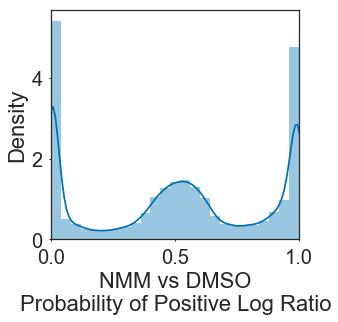

In [31]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.distplot(nmm.PPLR_NMM_6h_vs_DMSO_6h, bins=25, ax=ax, kde_kws={'bw': 0.025}, color=pal[0])
ax.set_xlim(0, 1)
ax.set_xticks([0, 0.5, 1])
ax.set_xlabel('NMM vs DMSO\nProbability of Positive Log Ratio')
ax.set_ylabel('Density')
plt.tight_layout()
plt.savefig('NMM_DMSO_pplr.svg')
plt.show()

In [32]:
annot = nmm.mrnaassignment.str.split('\s+///\s+', expand=True)
annot = annot.where(
    annot.apply(lambda col: col.str.contains('ENSEMBL'), axis=0))
annot['probe_cluster_id'] = nmm['Row.names']
annot = pd.melt(annot, id_vars='probe_cluster_id')
annot = (annot.drop('variable', axis=1)
              .dropna()
              .sort_values('probe_cluster_id'))
annot = annot.join(
    annot.value.str.split('\s+//\s+', expand=True)[[0, 2]]
)
annot = annot.drop('value', axis=1)
annot.columns = ['probe_cluster_id', 'transcript_id', 'desc']
annot = annot.join(
    annot['desc'].str.split('\s*[a-z]+:', expand=True)[[2, 3, 5]],
)
annot = annot.drop('desc', axis=1)
annot.columns = [
    'probe_cluster_id', 'transcript_id', 'loc', 'gene_id', 'description']
nmm_annot = annot.merge(
    nmm[['Row.names', 'DMSO_24h', 'DMSO_6h', 'NMM_24h', 'NMM_6h',
         'logFC_NMM_6h_vs_DMSO_6h', 'logFC_NMM_24h_vs_DMSO_24h', 
         'logFC_NMM_24h_vs_NMM_6h', 'PPLR_NMM_6h_vs_DMSO_6h',
         'PPLR_NMM_24h_vs_DMSO_24h', 'PPLR_NMM_24h_vs_NMM_6h']],
    left_on='probe_cluster_id',
    right_on='Row.names',
    how='left'
)
nmm_annot = nmm_annot.drop(['Row.names'], axis=1)
nmm_annot.head()

,probe_cluster_id,transcript_id,loc,gene_id,description,DMSO_24h,DMSO_6h,NMM_24h,NMM_6h,logFC_NMM_6h_vs_DMSO_6h,logFC_NMM_24h_vs_DMSO_24h,logFC_NMM_24h_vs_NMM_6h,PPLR_NMM_6h_vs_DMSO_6h,PPLR_NMM_24h_vs_DMSO_24h,PPLR_NMM_24h_vs_NMM_6h
0,13334158,AT1G01010.1,TAIR10:1:3631:5899:1,AT1G01010,NAC domain containing protein 1,6.328143,6.399972,6.584596,6.424296,0.024324,0.256453,0.160300,0.564014,0.955349,0.866938
1,13334167,AT1G01040.2,TAIR10:1:23416:31120:1,AT1G01040,dicer-like 1,6.732463,6.735422,6.822553,6.503099,-0.232322,0.090091,0.319454,0.013710,0.803795,0.999479
2,13334167,AT1G01040.1,TAIR10:1:23146:31227:1,AT1G01040,dicer-like 1,6.732463,6.735422,6.822553,6.503099,-0.232322,0.090091,0.319454,0.013710,0.803795,0.999479
3,13334192,AT1G01073.1,TAIR10:1:44677:44787:1,AT1G01073,unknown protein\x3b FUNCTIONS IN\x3a molecular...,3.939582,3.949629,3.992714,4.092797,0.143168,0.053131,-0.100084,0.912347,0.692513,0.161645
4,13334194,AT1G01110.1,TAIR10:1:52869:54685:1,AT1G01110,IQ-domain 18,5.484441,5.501032,5.472346,5.473653,-0.027379,-0.012095,-0.001307,0.289995,0.403435,0.489347


In [33]:
nmm_g4 = nmm_annot.merge(g4_max_density,
                         left_on='gene_id',
                         right_on='gene_id')
nmm_g4 = nmm_g4.drop_duplicates(subset=['gene_id',
                                        'logFC_NMM_6h_vs_DMSO_6h',
                                        'max_g4_density_coding',
                                        'max_g4_density_template'])
nmm_g4.head()

,probe_cluster_id,transcript_id,loc,gene_id,description,DMSO_24h,DMSO_6h,NMM_24h,NMM_6h,logFC_NMM_6h_vs_DMSO_6h,logFC_NMM_24h_vs_DMSO_24h,logFC_NMM_24h_vs_NMM_6h,PPLR_NMM_6h_vs_DMSO_6h,PPLR_NMM_24h_vs_DMSO_24h,PPLR_NMM_24h_vs_NMM_6h,max_g4_density_coding,max_g4_density_template
0,13334158,AT1G01010.1,TAIR10:1:3631:5899:1,AT1G01010,NAC domain containing protein 1,6.328143,6.399972,6.584596,6.424296,0.024324,0.256453,0.160300,0.564014,0.955349,0.866938,1,1
1,13334167,AT1G01040.2,TAIR10:1:23416:31120:1,AT1G01040,dicer-like 1,6.732463,6.735422,6.822553,6.503099,-0.232322,0.090091,0.319454,0.013710,0.803795,0.999479,1,1
3,13334194,AT1G01110.1,TAIR10:1:52869:54685:1,AT1G01110,IQ-domain 18,5.484441,5.501032,5.472346,5.473653,-0.027379,-0.012095,-0.001307,0.289995,0.403435,0.489347,2,2
5,13334204,AT1G01160.1,TAIR10:1:72339:74096:1,AT1G01160,GRF1-interacting factor 2,7.052670,7.193651,7.298092,7.040504,-0.153147,0.245423,0.257588,0.107099,0.976732,0.987058,1,1
7,13361898,AT1G01160.1,TAIR10:1:72339:74096:1,AT1G01160,GRF1-interacting factor 2,7.761860,7.808131,7.074020,7.311388,-0.496743,-0.687841,-0.237368,0.020351,0.002299,0.143867,1,1


In [35]:
berb = pd.read_table('/home/matthew/Documents/analysis_notebooks/tair10_nmm_6h_24h/data/berberine_data_2.txt',
                     sep = ' ', names = ['gene_id', 'Berberine_v_Cntrl_fch'])
berb.gene_id = [x.upper() for x in berb.gene_id]
nmm_v_berb = nmm_g4.merge(berb, on='gene_id')
nmm_v_berb.head()

,probe_cluster_id,transcript_id,loc,gene_id,description,DMSO_24h,DMSO_6h,NMM_24h,NMM_6h,logFC_NMM_6h_vs_DMSO_6h,logFC_NMM_24h_vs_DMSO_24h,logFC_NMM_24h_vs_NMM_6h,PPLR_NMM_6h_vs_DMSO_6h,PPLR_NMM_24h_vs_DMSO_24h,PPLR_NMM_24h_vs_NMM_6h,max_g4_density_coding,max_g4_density_template,Berberine_v_Cntrl_fch
0,13334270,AT1G01300.1,TAIR10:1:116943:118764:1,AT1G01300,Eukaryotic aspartyl protease family protein,6.408969,6.500450,6.170648,5.949653,-0.550797,-0.238322,0.220995,0.000133,0.057273,0.944970,1,3,-0.7
1,13334292,AT1G01360.1,TAIR10:1:141971:143183:1,AT1G01360,regulatory component of ABA receptor 1,5.084500,5.084490,5.082248,5.086496,0.002006,-0.002252,-0.004248,0.531248,0.464919,0.433907,1,0,-0.6
2,13334349,AT1G01500.1,TAIR10:1:185133:186923:1,AT1G01500,Erythronate-4-phosphate dehydrogenase family p...,5.196201,5.481082,5.853750,5.899223,0.418141,0.657548,-0.045473,0.996827,0.999991,0.371846,2,2,0.7
3,13334429,AT1G01630.1,TAIR10:1:229013:230917:1,AT1G01630,Sec14p-like phosphatidylinositol transfer fami...,8.914182,8.873110,8.110465,7.875611,-0.997499,-0.803717,0.234853,0.000004,0.000162,0.876906,1,0,0.5
4,13334490,AT1G01750.1,TAIR10:1:275366:276310:1,AT1G01750,actin depolymerizing factor 11,5.106203,5.254778,4.541851,4.542580,-0.712198,-0.564351,-0.000729,0.000041,0.000898,0.498230,1,2,-2.0


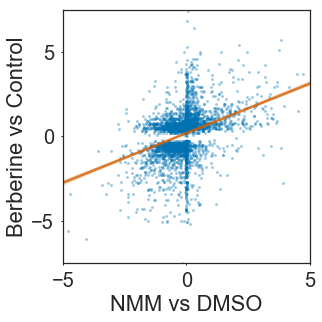

In [36]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.regplot(x='logFC_NMM_6h_vs_DMSO_6h',
            y='Berberine_v_Cntrl_fch',
            data=nmm_v_berb,
            scatter_kws={'alpha': 0.4, 'color': pal[0], 's': 8, 'rasterized': True},
            line_kws={'color': pal[1], 'alpha': 0.8},
            n_boot=10,
            robust=True)
ax.set_xlim(-5, 5)
ax.set_ylim(-7.5, 7.5)
ax.set_xticks([-5, 0, 5])
ax.set_yticks([-5, 0, 5])
ax.set_ylabel('Berberine vs Control')
ax.set_xlabel('NMM vs DMSO')
plt.tight_layout()
plt.savefig('nmm_berberine_scatter.svg', transparent=True)
plt.show()

522 3743 1072 1243
1.13459098535e-36


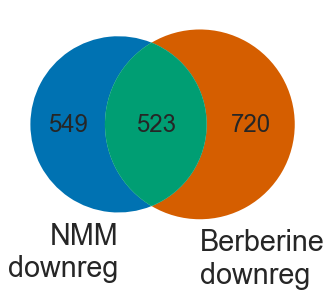

In [37]:
nmm_v_berb['downreg_nmm'] = ((nmm_v_berb.PPLR_NMM_6h_vs_DMSO_6h < 0.1) &
                             (nmm_v_berb.logFC_NMM_6h_vs_DMSO_6h < -0.5))
nmm_v_berb['downreg_berb'] = nmm_v_berb.Berberine_v_Cntrl_fch < -0.5
nmm_downreg = set(nmm_v_berb.loc[nmm_v_berb.downreg_nmm, 'gene_id'])
berb_dowreg = set(nmm_v_berb.loc[nmm_v_berb.downreg_berb, 'gene_id'])

print(len(nmm_downreg.intersection(berb_dowreg)) - 1,
      len(set(nmm_v_berb.gene_id)),
      len(nmm_downreg),
      len(berb_dowreg))
print(stats.hypergeom.sf(
    len(nmm_downreg.intersection(berb_dowreg)) - 1,
    len(set(nmm_v_berb.gene_id)),
    len(nmm_downreg),
    len(berb_dowreg),
))

venn = vn.venn2(
    [nmm_downreg, berb_dowreg],
    set_labels=['NMM\ndownreg', 'Berberine\ndownreg'],
    set_colors=pal[:2],
    alpha=1
)
venn.get_patch_by_id('11').set_color(pal[2])
plt.tight_layout()
plt.savefig('nmm_berberine_venn.svg')
plt.show()

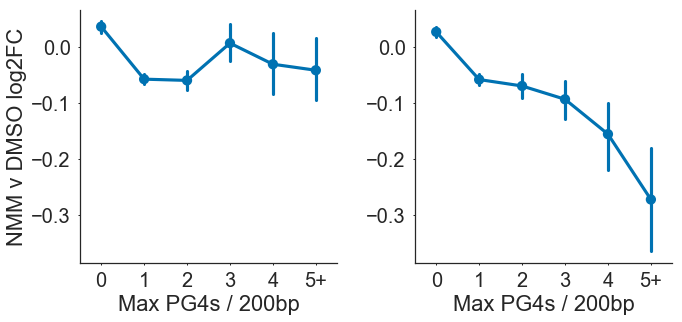

In [38]:
nmm_g4['max_g4_density_cut_template'] = pd.cut(
    nmm_g4.max_g4_density_template,
    bins=[-1, 0, 1, 2, 3, 4, np.inf],
    labels=['0', '1', '2', '3', '4', '5+'],
    right=True,
)
nmm_g4['max_g4_density_cut_coding'] = pd.cut(
    nmm_g4.max_g4_density_coding,
    bins=[-1, 0, 1, 2, 3, 4, np.inf],
    labels=['0', '1', '2', '3', '4', '5+'],
    right=True,
)

nmm_g4_long = pd.melt(nmm_g4,
        id_vars=['gene_id', 'logFC_NMM_6h_vs_DMSO_6h'],
        value_vars=['max_g4_density_cut_coding', 'max_g4_density_cut_template'],
        var_name='strand', value_name='max_g4_density')

g = sns.FacetGrid(data=nmm_g4_long, col='strand', size=5)
g.map(sns.pointplot,
      'max_g4_density',
      'logFC_NMM_6h_vs_DMSO_6h',
      order=['0', '1', '2', '3', '4', '5+'])
g.set_xlabels('Max PG4s / 200bp')
g.set_ylabels('NMM v DMSO log2FC')
g.set_titles('')
plt.tight_layout()
plt.savefig('nmm_exprs_g4_max_density.svg')
plt.show()

In [39]:
%%bash
source activate cgat_python2
g4predict intra \
  -f /home/matthew/Documents/genomes/tair10/fasta/tair10_genome.fa \
  -b /tmp/tair10_g4.bed \
  -F \
  -s \
  -tmin 2 \
  -tmax 6 \
  -lmin 1 \
  -lmax 7

INFO:root:Output from G4Predict
INFO:root:Parsing command line arguments
INFO:root:Running in mode: intra
INFO:root:Parameters:
{       'bed': '/tmp/tair10_g4.bed',
        'fasta': '/home/matthew/Documents/genomes/tair10/fasta/tair10_genome.fa',
        'filter_overlapping': True,
        'func': <function intra at 0x7f943cd4db90>,
        'merge_overlapping': False,
        'write_bed12': False,
        'write_bed6': True}
INFO:root:G4 Parameters: 
{       'bulge_kwargs': {       'bulges_allowed': 0, 'start': 1, 'stop': 5},
        'inter_kwargs': {       'start': 2, 'stop': 3},
        'loop_kwargs_list': [       {       'allow_G': 1, 'start': 1, 'stop': 7},
                                    {       'allow_G': 1, 'start': 1, 'stop': 7},
                                    {       'allow_G': 1, 'start': 1, 'stop': 7}],
        'score_kwargs': {       'bulge_pen_factor': 5,
                                'loop_pen_factor': 1.5,
                                'tetrad_score_factor':

In [40]:
%%bash
source activate jupyter_python3

bedtools makewindows \
  -g /home/matthew/Documents/genomes/tair10/tair10.chrom.sizes \
  -w 200 -s 25 -i srcwinnum | tee >(\
    awk -v OFS="\t" '{print $0 "_pos", ".", "+"}'  > /tmp/windows_pos.bed) | \
    awk -v OFS="\t" '{print $0 "_neg", ".", "-"}'  > /tmp/windows_neg.bed
cat /tmp/windows_pos.bed /tmp/windows_neg.bed | \
sort -k1,1 -k2,2n > /tmp/windows.bed

In [41]:
!head /tmp/windows.bed

1	0	200	1_1_neg	.	-
1	0	200	1_1_pos	.	+
1	25	225	1_2_neg	.	-
1	25	225	1_2_pos	.	+
1	50	250	1_3_neg	.	-
1	50	250	1_3_pos	.	+
1	75	275	1_4_neg	.	-
1	75	275	1_4_pos	.	+
1	100	300	1_5_neg	.	-
1	100	300	1_5_pos	.	+


In [42]:
%%bash
source activate jupyter_python3

bedtools map -c 4 -o count -s \
  -a /tmp/windows.bed \
  -b /tmp/tair10_g4.bed | \
awk -v OFS="\t" '{print $1, $2, $3, $4, $7, $6}' \
  > /tmp/g4_windowed_counts.bed

In [43]:
!head /tmp/g4_windowed_counts.bed

1	0	200	1_1_neg	3	-
1	0	200	1_1_pos	0	+
1	25	225	1_2_neg	2	-
1	25	225	1_2_pos	0	+
1	50	250	1_3_neg	2	-
1	50	250	1_3_pos	0	+
1	75	275	1_4_neg	1	-
1	75	275	1_4_pos	0	+
1	100	300	1_5_neg	1	-
1	100	300	1_5_pos	0	+


In [44]:
%%bash
source activate jupyter_python3

bedtools map -c 5 -o max -s -prec 1 -F 0.75 \
  -a /home/matthew/Documents/genomes/tair10/gff/araport11_genes.bed \
  -b /tmp/g4_windowed_counts.bed > /tmp/g4_pos_maximal_density.bed

bedtools map -c 5 -o max -S -prec 1 -F 0.75 \
  -a /home/matthew/Documents/genomes/tair10/gff/araport11_genes.bed \
  -b /tmp/g4_windowed_counts.bed > /tmp/g4_neg_maximal_density.bed

In [45]:
%%bash
source activate cgat_python2

cgat gtf2gtf --method=merge-transcripts --filter=proteincoding \
  -I /home/matthew/Documents/genomes/tair10/gff/Araport11_GFF3_genes_transposons.201606.gtf \
  -L /dev/null |
awk -v OFS='\t' '{print $1, $4 - 1, $5, $10, ".", $7}' | sed 's/[";]//g' > /tmp/araport11_genes.bed

In [46]:
%%bash
source activate jupyter_python3

join -j 1 -t $'\t' <( 
    bedtools intersect -c -s -F 1 \
      -a /tmp/araport11_genes.bed \
      -b /tmp/tair10_g4.bed | \
    awk -v OFS='\t' '{print $4,$7,$7/($3-$2)*1000}') \
           <(
    bedtools intersect -c -S -F 1 \
      -a /tmp/araport11_genes.bed \
      -b /tmp/tair10_g4.bed | \
    awk -v OFS='\t' '{print $4,$7,$7/($3-$2)*1000}') \
    > /tmp/genic_g4_counts.tsv

In [47]:
!head exons.bed

1	3630	3913	AT1G01010	.	+
1	3995	4276	AT1G01010	.	+
1	4485	4605	AT1G01010	.	+
1	4705	5095	AT1G01010	.	+
1	5173	5326	AT1G01010	.	+
1	5438	5899	AT1G01010	.	+
1	6787	7069	AT1G01020	.	-
1	7156	7450	AT1G01020	.	-
1	7563	7649	AT1G01020	.	-
1	7761	7835	AT1G01020	.	-


In [48]:
%%bash
source activate cgat_python2
cgat gtf2gtf --method=exons2introns --filter=proteincoding \
  -I /home/matthew/Documents/genomes/tair10/gff/Araport11_GFF3_genes_transposons.201606.gtf \
  -L /dev/null | \
awk -v OFS='\t' '{print $1, $4 - 1, $5, $10, ".", $7}' | sed 's/[";]//g' > introns.bed

cgat gtf2gtf --method=merge-exons --filter=proteincoding \
  -I /home/matthew/Documents/genomes/tair10/gff/Araport11_GFF3_genes_transposons.201606.gtf \
  -L /dev/null | \
awk -v OFS='\t' '{print $1, $4 - 1, $5, $10, ".", $7}' | sed 's/[";]//g' > exons.bed

cgat gtf2gtf --method="merge-exons" --filter="proteincoding" --mark-utr \
  -I /home/matthew/Documents/genomes/tair10/gff/Araport11_GFF3_genes_transposons.201606.gtf \
  -L /dev/null | \
awk -v OFS='\t' '$3 == "CDS" {print $1, $4 - 1, $5, $10, ".", $7}' | sed 's/[";]//g' > cds.bed

cgat gtf2gtf --method="merge-exons" --filter="proteincoding" --mark-utr \
  -I /home/matthew/Documents/genomes/tair10/gff/Araport11_GFF3_genes_transposons.201606.gtf \
  -L /dev/null | \
awk -v OFS='\t' '$3 == "UTR5" {print $1, $4 - 1, $5, $10, ".", $7}' | sed 's/[";]//g' > utr5.bed

cgat gtf2gtf --method="merge-exons" --filter="proteincoding" --mark-utr \
  -I /home/matthew/Documents/genomes/tair10/gff/Araport11_GFF3_genes_transposons.201606.gtf \
  -L /dev/null | \
awk -v OFS='\t' '$3 == "UTR3" {print $1, $4 - 1, $5, $10, ".", $7}' | sed 's/[";]//g' > utr3.bed

join -j 1 -t $'\t' <( 
    bedtools intersect -c -s \
      -a exons.bed\
      -b /tmp/tair10_g4.bed | \
    awk -v OFS='\t' '{count[$4]+=$7; len[$4]+=($3-$2)} END \
                     {for (i in count) {print i,count[i],count[i]/(len[i]+1)*1000}}' | \
    sort -k1,1d) \
           <(
    bedtools intersect -c -S \
      -a exons.bed \
      -b /tmp/tair10_g4.bed | \
    awk -v OFS='\t' '{count[$4]+=$7; len[$4]+=($3-$2)} END \
                     {for (i in count) {print i,count[i],count[i]/(len[i])*1000}}' | \
    sort -k1,1d) \
    > ./exonic_g4_counts.tsv

join -j 1 -t $'\t' <( 
    bedtools intersect -c -s \
      -a introns.bed\
      -b /tmp/tair10_g4.bed | \
    awk -v OFS='\t' '{count[$4]+=$7; len[$4]+=($3-$2)} END \
                     {for (i in count) {print i,count[i],count[i]/(len[i])*1000}}' | \
    sort -k1,1d) \
           <(
    bedtools intersect -c -S \
      -a introns.bed \
      -b /tmp/tair10_g4.bed | \
    awk -v OFS='\t' '{count[$4]+=$7; len[$4]+=($3-$2)} END \
                     {for (i in count) {print i,count[i],count[i]/(len[i])*1000}}' | \
    sort -k1,1d) \
    > ./intronic_g4_counts.tsv

join -j 1 -t $'\t' <( 
    bedtools intersect -c -s \
      -a cds.bed\
      -b /tmp/tair10_g4.bed | \
    awk -v OFS='\t' '{count[$4]+=$7; len[$4]+=($3-$2)} END \
                     {for (i in count) {print i,count[i],count[i]/(len[i])*1000}}' | \
    sort -k1,1d) \
           <(
    bedtools intersect -c -S \
      -a cds.bed \
      -b /tmp/tair10_g4.bed | \
    awk -v OFS='\t' '{count[$4]+=$7; len[$4]+=($3-$2)} END \
                     {for (i in count) {print i,count[i],count[i]/(len[i])*1000}}' | \
    sort -k1,1d) \
    > ./cds_g4_counts.tsv

join -j 1 -t $'\t' <( 
    bedtools intersect -c -s \
      -a utr5.bed\
      -b /tmp/tair10_g4.bed | \
    awk -v OFS='\t' '{count[$4]+=$7; len[$4]+=($3-$2)} END \
                     {for (i in count) {print i,count[i],count[i]/(len[i])*1000}}' | \
    sort -k1,1d) \
           <(
    bedtools intersect -c -S \
      -a utr5.bed \
      -b /tmp/tair10_g4.bed | \
    awk -v OFS='\t' '{count[$4]+=$7; len[$4]+=($3-$2)} END \
                     {for (i in count) {print i,count[i],count[i]/(len[i])*1000}}' | \
    sort -k1,1d) \
    > ./utr5_g4_counts.tsv

join -j 1 -t $'\t' <( 
    bedtools intersect -c -s \
      -a utr3.bed\
      -b /tmp/tair10_g4.bed | \
    awk -v OFS='\t' '{count[$4]+=$7; len[$4]+=($3-$2)} END \
                     {for (i in count) {print i,count[i],count[i]/(len[i])*1000}}' | \
    sort -k1,1d) \
           <(
    bedtools intersect -c -S \
      -a utr3.bed \
      -b /tmp/tair10_g4.bed | \
    awk -v OFS='\t' '{count[$4]+=$7; len[$4]+=($3-$2)} END \
                     {for (i in count) {print i,count[i],count[i]/(len[i])*1000}}' | \
    sort -k1,1d) \
    > ./utr3_g4_counts.tsv

In [49]:
g4_counts = pd.read_table('/tmp/genic_g4_counts.tsv',
                          sep='\t',
                          names=['gene_id', 'coding_g4', 'coding_g4_dens',
                                 'template_g4', 'template_g4_dens'])
g4_counts_exon = pd.read_table(
    'exonic_g4_counts.tsv',
    sep='\t',
    names=['gene_id',
           'exon_coding_g4', 'exon_coding_g4_dens',
           'exon_template_g4', 'exon_template_g4_dens']
)
g4_counts_intron = pd.read_table(
    'intronic_g4_counts.tsv',
    sep='\t',
    names=['gene_id',
           'intron_coding_g4', 'intron_coding_g4_dens',
           'intron_template_g4', 'intron_template_g4_dens']
)
g4_counts_cds = pd.read_table(
    'cds_g4_counts.tsv',
    sep='\t',
    names=['gene_id',
           'cds_coding_g4', 'cds_coding_g4_dens',
           'cds_template_g4', 'cds_template_g4_dens']
)
g4_counts_utr5 = pd.read_table(
    'utr5_g4_counts.tsv',
    sep='\t',
    names=['gene_id',
           'utr5_coding_g4', 'utr5_coding_g4_dens',
           'utr5_template_g4', 'utr5_template_g4_dens']
)
g4_counts_utr3 = pd.read_table(
    'utr3_g4_counts.tsv',
    sep='\t',
    names=['gene_id',
           'utr3_coding_g4', 'utr3_coding_g4_dens',
           'utr3_template_g4', 'utr3_template_g4_dens']
)
g4_counts_exon_intron = g4_counts_exon.merge(g4_counts_intron, how='outer').fillna(0)
g4_counts_exon_intron = g4_counts_exon_intron.merge(g4_counts_cds, how='outer').fillna(0)
g4_counts_exon_intron = g4_counts_exon_intron.merge(g4_counts_utr5, how='outer').fillna(0)
g4_counts_exon_intron = g4_counts_exon_intron.merge(g4_counts_utr3, how='outer').fillna(0)
nmm_g4_tot = nmm_g4.merge(g4_counts, on='gene_id').merge(g4_counts_exon_intron, on='gene_id')
nmm_g4_tot.head(n=10)

,probe_cluster_id,transcript_id,loc,gene_id,description,DMSO_24h,DMSO_6h,NMM_24h,NMM_6h,logFC_NMM_6h_vs_DMSO_6h,...,cds_template_g4,cds_template_g4_dens,utr5_coding_g4,utr5_coding_g4_dens,utr5_template_g4,utr5_template_g4_dens,utr3_coding_g4,utr3_coding_g4_dens,utr3_template_g4,utr3_template_g4_dens
0,13334158,AT1G01010.1,TAIR10:1:3631:5899:1,AT1G01010,NAC domain containing protein 1,6.328143,6.399972,6.584596,6.424296,0.024324,...,2.0,1.550390,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,13334167,AT1G01040.2,TAIR10:1:23416:31120:1,AT1G01040,dicer-like 1,6.732463,6.735422,6.822553,6.503099,-0.232322,...,2.0,0.348857,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,13334194,AT1G01110.1,TAIR10:1:52869:54685:1,AT1G01110,IQ-domain 18,5.484441,5.501032,5.472346,5.473653,-0.027379,...,4.0,2.525250,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,13334204,AT1G01160.1,TAIR10:1:72339:74096:1,AT1G01160,GRF1-interacting factor 2,7.052670,7.193651,7.298092,7.040504,-0.153147,...,2.0,2.898550,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,13361898,AT1G01160.1,TAIR10:1:72339:74096:1,AT1G01160,GRF1-interacting factor 2,7.761860,7.808131,7.074020,7.311388,-0.496743,...,2.0,2.898550,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
5,13334204,AT1G01170.2,TAIR10:1:73931:74731:-1,AT1G01170,Protein of unknown function (DUF1138),7.052670,7.193651,7.298092,7.040504,-0.153147,...,1.0,3.968250,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
6,13361898,AT1G01170.1,TAIR10:1:73931:74737:-1,AT1G01170,Protein of unknown function (DUF1138),7.761860,7.808131,7.074020,7.311388,-0.496743,...,1.0,3.968250,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
7,13334213,AT1G01180.1,TAIR10:1:75583:76758:1,AT1G01180,S-adenosyl-L-methionine-dependent methyltransf...,4.613214,4.765109,4.860757,5.312210,0.547101,...,1.0,1.082250,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
8,13334217,AT1G01210.1,TAIR10:1:88898:89745:1,AT1G01210,"DNA-directed RNA polymerase, subunit M, archaeal",5.922870,5.911431,5.941785,5.716870,-0.194562,...,0.0,0.000000,1.0,4.92611,0.0,0.0,0.0,0.0,0.0,0.0
9,13334223,AT1G01220.1,TAIR10:1:91376:95651:1,AT1G01220,L-fucokinase/GDP-L-fucose pyrophosphorylase,6.776179,6.736849,6.496884,6.106150,-0.630698,...,1.0,0.313283,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0


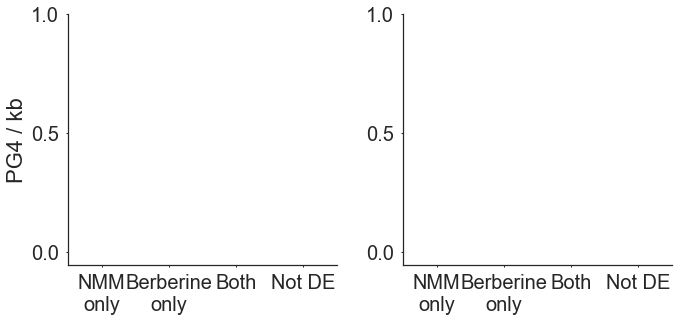

In [50]:
nmm_v_berb_long = pd.melt(
    nmm_v_berb.drop_duplicates(subset=['gene_id']),
    id_vars=['gene_id', 'downreg_nmm', 'downreg_berb'],
    value_vars=['exon_coding_g4_dens', 'exon_template_g4_dens'],
    var_name='strand', value_name='g4_density')
nmm_v_berb_long['neither'] = ~(nmm_v_berb_long.downreg_nmm | nmm_v_berb_long.downreg_berb)
nmm_v_berb_long['downreg_both'] = nmm_v_berb_long.downreg_nmm & nmm_v_berb_long.downreg_berb
nmm_v_berb_long.loc[nmm_v_berb_long.downreg_both, ['downreg_nmm', 'downreg_berb']] = False
nmm_v_berb_long['cond'] = nmm_v_berb_long[['downreg_nmm', 'downreg_berb', 'downreg_both', 'neither']].idxmax(1)

g = sns.factorplot(x='cond',
                   y='g4_density',
                   col='strand',
                   kind='bar',
                   data=nmm_v_berb_long,
                   order=['downreg_nmm', 'downreg_berb', 'downreg_both', 'neither'],
                   size=5)
g.axes.squeeze()[0].set_title('')
g.axes.squeeze()[1].set_title('')
g.set_xlabels('')
g.set_xticklabels(['NMM\nonly', 'Berberine\nonly', 'Both', 'Not DE'])
g.set_ylabels('PG4 / kb')
a1, = plt.bar([0], [0], 0, color=pal[0])
a2, = plt.bar([0], [0], 0, color=pal[1])
for ax in g.axes.ravel():
    ax.set_yticks([0, 0.5, 1])
plt.tight_layout()
plt.savefig('nmm_berb_venn_subsets_g4_exon.svg')
plt.show()

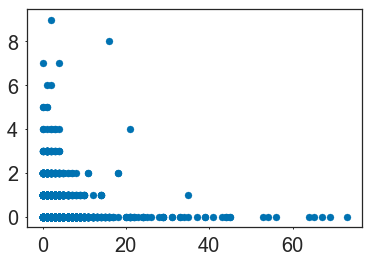

In [51]:
plt.scatter(x='exon_template_g4', y='intron_template_g4', data=nmm_g4_tot)
plt.show()

In [52]:
nmm_g4_tot['upreg'] = ((nmm_g4_tot.PPLR_NMM_6h_vs_DMSO_6h > 0.9) &
                       (nmm_g4_tot.logFC_NMM_6h_vs_DMSO_6h > 0.5))
nmm_g4_tot['strong_upreg'] = ((nmm_g4_tot.PPLR_NMM_6h_vs_DMSO_6h > 0.9) &
                             (nmm_g4_tot.logFC_NMM_6h_vs_DMSO_6h > 1))
nmm_g4_tot['downreg'] = ((nmm_g4_tot.PPLR_NMM_6h_vs_DMSO_6h < 0.1) &
                         (nmm_g4_tot.logFC_NMM_6h_vs_DMSO_6h < -0.5))
nmm_g4_tot['strong_downreg'] = ((nmm_g4_tot.PPLR_NMM_6h_vs_DMSO_6h < 0.1) &
                               (nmm_g4_tot.logFC_NMM_6h_vs_DMSO_6h < -1))
nmm_g4_tot['notDE'] = ~nmm_g4_tot.upreg & ~nmm_g4_tot.downreg
nmm_g4_tot['cond'] = nmm_g4_tot[['upreg', 'downreg', 'notDE']].idxmax(1)
nmm_g4_tot['strong_cond'] = nmm_g4_tot.strong_upreg | nmm_g4_tot.strong_downreg

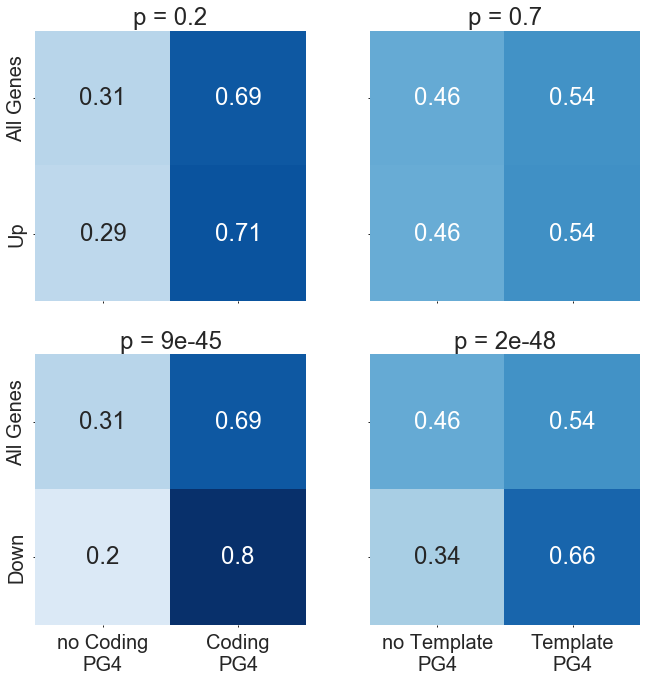

In [53]:
fig, axes = plt.subplots(figsize=(10, 10), nrows=2, ncols=2)

strand_g4 = [
    nmm_g4_tot.drop_duplicates('gene_id').coding_g4.astype(bool),
    nmm_g4_tot.drop_duplicates('gene_id').template_g4.astype(bool),
]

notde = nmm_g4_tot.drop_duplicates('gene_id')['notDE'].values

de_sets = [
    nmm_g4_tot.drop_duplicates('gene_id')['upreg'].values,
    nmm_g4_tot.drop_duplicates('gene_id')['downreg'].values
]

for j, (g4, strand) in enumerate(zip(strand_g4, ['Coding', 'Template'])):
    for i, (de, lab) in enumerate(zip(de_sets, ['Up', 'Down'])):
        nde = np.asarray([sum(~g4),
                          sum(g4)])
        dr = np.asarray([sum(~g4 & de),
                         sum(g4 & de)])
        nde = nde / nde.sum()
        exp = nde * dr.sum()
        _, p = stats.chisquare(dr, exp)
        dr = dr / dr.sum()
        mat = np.asarray([nde, dr])
        sns.heatmap(mat,
                    cmap='Blues',
                    annot=True,
                    square=True,
                    xticklabels=['no {}\nPG4'.format(strand),
                                 '{}\nPG4'.format(strand)],
                    yticklabels=['All Genes', lab],
                    ax=axes[i][j],
                    vmin=0.1, vmax=0.8,
                    cbar=False)
        axes[i][j].set_title('p = {:.1g}'.format(p))
for ax in axes.ravel():
    plt.setp(ax.get_yticklabels(), va='center')
for ax in axes[0]:
    ax.set_xticklabels(['', ''])
for ax in axes[:, 1]:
    ax.set_yticklabels(['', ''])
plt.tight_layout()
plt.savefig('nmm_g4_presence_absence_chisquared.svg')
plt.show()

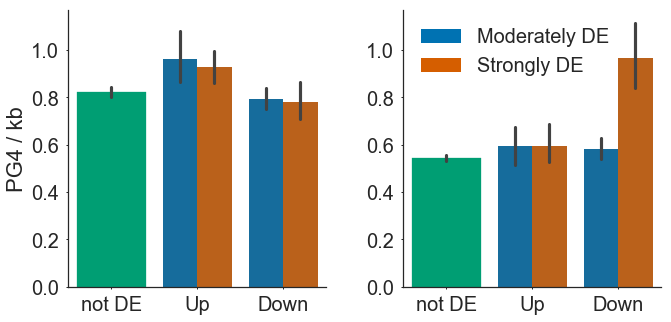

In [54]:
nmm_g4_long = pd.melt(
    nmm_g4_tot.drop_duplicates(subset=['gene_id']),
    id_vars=['gene_id', 'logFC_NMM_6h_vs_DMSO_6h', 'cond', 'strong_cond'],
    value_vars=['coding_g4_dens', 'template_g4_dens'],
    var_name='strand', value_name='g4_density')

g = sns.factorplot(x='cond',
                   y='g4_density',
                   hue='strong_cond',
                   col='strand',
                   kind='bar',
                   order=['notDE', 'upreg', 'downreg'],
                   data=nmm_g4_long,
                   legend=False,
                   size=5)
w = g.axes.squeeze()[0].patches[0].get_width()
g.axes.squeeze()[0].patches[0].set_color(pal[2])
g.axes.squeeze()[0].patches[0].set_color(pal[2])
g.axes.squeeze()[0].patches[0].set_width(w * 2)
g.axes.squeeze()[0].lines[0].set_xdata([0, 0])
g.axes.squeeze()[1].patches[0].set_color(pal[2])
g.axes.squeeze()[1].patches[0].set_width(w * 2)
g.axes.squeeze()[1].lines[0].set_xdata([0, 0])
g.axes.squeeze()[0].set_title('')
g.axes.squeeze()[1].set_title('')
g.set_xlabels('')
g.set_ylabels('PG4 / kb')
g.set_xticklabels(['not DE', 'Up', 'Down'])
a1, = plt.bar([0], [0], 0, color=pal[0])
a2, = plt.bar([0], [0], 0, color=pal[1])
plt.legend([a1, a2], ['Moderately DE', 'Strongly DE'])
plt.tight_layout()
plt.savefig('./g4_density_full_gene_body.svg')
plt.savefig('./g4_density_full_gene_body.png')
plt.show()

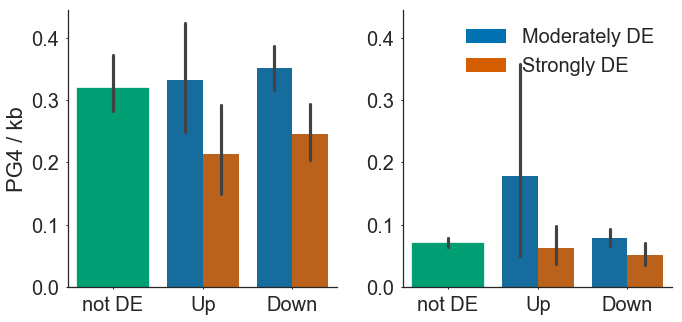

In [55]:
nmm_g4_long = pd.melt(
    nmm_g4_tot.drop_duplicates(subset=['gene_id']),
    id_vars=['gene_id', 'logFC_NMM_6h_vs_DMSO_6h', 'cond', 'strong_cond'],
    value_vars=['intron_coding_g4_dens', 'intron_template_g4_dens'],
    var_name='strand', value_name='g4_density')

g = sns.factorplot(x='cond',
                   y='g4_density',
                   hue='strong_cond',
                   col='strand',
                   kind='bar',
                   order=['notDE', 'upreg', 'downreg'],
                   data=nmm_g4_long,
                   legend=False,
                   size=5)
w = g.axes.squeeze()[0].patches[0].get_width()
g.axes.squeeze()[0].patches[0].set_color(pal[2])
g.axes.squeeze()[0].patches[0].set_color(pal[2])
g.axes.squeeze()[0].patches[0].set_width(w * 2)
g.axes.squeeze()[0].lines[0].set_xdata([0, 0])
g.axes.squeeze()[1].patches[0].set_color(pal[2])
g.axes.squeeze()[1].patches[0].set_width(w * 2)
g.axes.squeeze()[1].lines[0].set_xdata([0, 0])
g.axes.squeeze()[0].set_title('')
g.axes.squeeze()[1].set_title('')
g.set_xlabels('')
g.set_ylabels('PG4 / kb')
g.set_xticklabels(['not DE', 'Up', 'Down'])
a1, = plt.bar([0], [0], 0, color=pal[0])
a2, = plt.bar([0], [0], 0, color=pal[1])
plt.legend([a1, a2], ['Moderately DE', 'Strongly DE'], loc=0)
plt.tight_layout()
plt.savefig('./g4_density_intron.svg')
plt.savefig('./g4_density_intron.png')
plt.show()

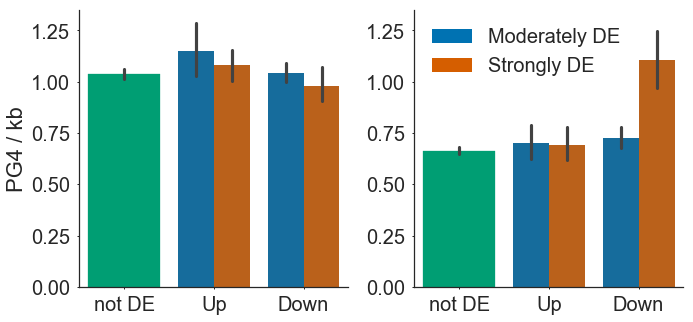

In [56]:
nmm_g4_long = pd.melt(
    nmm_g4_tot.drop_duplicates(subset=['gene_id']),
    id_vars=['gene_id', 'logFC_NMM_6h_vs_DMSO_6h', 'cond', 'strong_cond'],
    value_vars=['exon_coding_g4_dens', 'exon_template_g4_dens'],
    var_name='strand', value_name='g4_density')

g = sns.factorplot(x='cond',
                   y='g4_density',
                   hue='strong_cond',
                   col='strand',
                   kind='bar',
                   order=['notDE', 'upreg', 'downreg'],
                   data=nmm_g4_long,
                   legend=False,
                   size=5)
w = g.axes.squeeze()[0].patches[0].get_width()
g.axes.squeeze()[0].patches[0].set_color(pal[2])
g.axes.squeeze()[0].patches[0].set_color(pal[2])
g.axes.squeeze()[0].patches[0].set_width(w * 2)
g.axes.squeeze()[0].lines[0].set_xdata([0, 0])
g.axes.squeeze()[1].patches[0].set_color(pal[2])
g.axes.squeeze()[1].patches[0].set_width(w * 2)
g.axes.squeeze()[1].lines[0].set_xdata([0, 0])
g.axes.squeeze()[0].set_title('')
g.axes.squeeze()[1].set_title('')
g.set_xlabels('')
g.set_ylabels('PG4 / kb')
g.set_xticklabels(['not DE', 'Up', 'Down'])
plt.tight_layout()
a1, = plt.bar([0], [0], 0, color=pal[0])
a2, = plt.bar([0], [0], 0, color=pal[1])
plt.legend([a1, a2], ['Moderately DE', 'Strongly DE'], loc=0)
plt.savefig('./g4_density_exon.svg')
plt.savefig('./g4_density_exon.png')
plt.show()

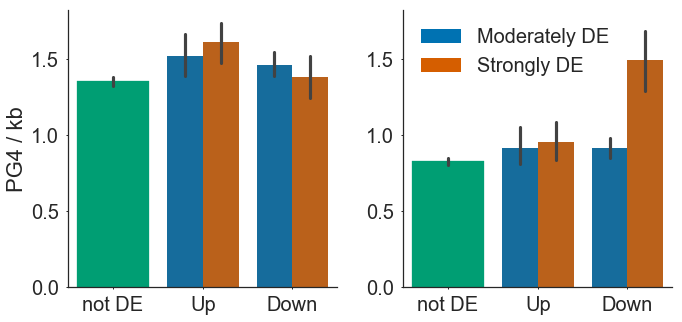

In [57]:
nmm_g4_long = pd.melt(
    nmm_g4_tot.drop_duplicates(subset=['gene_id']),
    id_vars=['gene_id', 'logFC_NMM_6h_vs_DMSO_6h', 'cond', 'strong_cond'],
    value_vars=['cds_coding_g4_dens', 'cds_template_g4_dens'],
    var_name='strand', value_name='g4_density')

g = sns.factorplot(x='cond',
                   y='g4_density',
                   hue='strong_cond',
                   col='strand',
                   kind='bar',
                   order=['notDE', 'upreg', 'downreg'],
                   data=nmm_g4_long, 
                   legend=False,
                   size=5)
w = g.axes.squeeze()[0].patches[0].get_width()
g.axes.squeeze()[0].patches[0].set_color(pal[2])
g.axes.squeeze()[0].patches[0].set_color(pal[2])
g.axes.squeeze()[0].patches[0].set_width(w * 2)
g.axes.squeeze()[0].lines[0].set_xdata([0, 0])
g.axes.squeeze()[1].patches[0].set_color(pal[2])
g.axes.squeeze()[1].patches[0].set_width(w * 2)
g.axes.squeeze()[1].lines[0].set_xdata([0, 0])
g.axes.squeeze()[0].set_title('')
g.axes.squeeze()[1].set_title('')
g.set_xlabels('')
g.set_ylabels('PG4 / kb')
g.set_xticklabels(['not DE', 'Up', 'Down'])
plt.tight_layout()
a1, = plt.bar([0], [0], 0, color=pal[0])
a2, = plt.bar([0], [0], 0, color=pal[1])
plt.legend([a1, a2], ['Moderately DE', 'Strongly DE'], loc=0)
plt.savefig('./g4_density_cds.svg')
plt.savefig('./g4_density_cds.png')
plt.show()

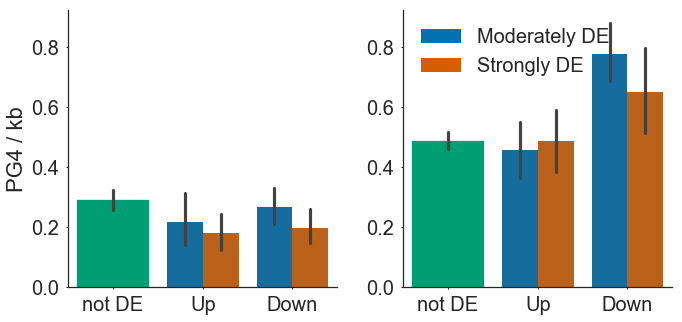

In [58]:
nmm_g4_long = pd.melt(
    nmm_g4_tot.drop_duplicates(subset=['gene_id']),
    id_vars=['gene_id', 'logFC_NMM_6h_vs_DMSO_6h', 'cond', 'strong_cond'],
    value_vars=['utr5_coding_g4_dens', 'utr5_template_g4_dens'],
    var_name='strand', value_name='g4_density')

g = sns.factorplot(x='cond',
                   y='g4_density',
                   hue='strong_cond',
                   col='strand',
                   kind='bar',
                   order=['notDE', 'upreg', 'downreg'],
                   data=nmm_g4_long, 
                   legend=False,
                   size=5)
w = g.axes.squeeze()[0].patches[0].get_width()
g.axes.squeeze()[0].patches[0].set_color(pal[2])
g.axes.squeeze()[0].patches[0].set_color(pal[2])
g.axes.squeeze()[0].patches[0].set_width(w * 2)
g.axes.squeeze()[0].lines[0].set_xdata([0, 0])
g.axes.squeeze()[1].patches[0].set_color(pal[2])
g.axes.squeeze()[1].patches[0].set_width(w * 2)
g.axes.squeeze()[1].lines[0].set_xdata([0, 0])
g.axes.squeeze()[0].set_title('')
g.axes.squeeze()[1].set_title('')
g.set_xlabels('')
g.set_ylabels('PG4 / kb')
g.set_xticklabels(['not DE', 'Up', 'Down'])
plt.tight_layout()
a1, = plt.bar([0], [0], 0, color=pal[0])
a2, = plt.bar([0], [0], 0, color=pal[1])
plt.legend([a1, a2], ['Moderately DE', 'Strongly DE'], loc=0)
plt.savefig('./g4_density_utr5.svg')
plt.savefig('./g4_density_utr5.png')
plt.show()

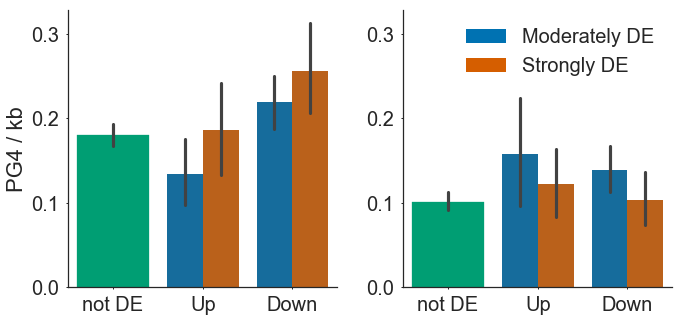

In [59]:
nmm_g4_long = pd.melt(
    nmm_g4_tot.drop_duplicates(subset=['gene_id']),
    id_vars=['gene_id', 'logFC_NMM_6h_vs_DMSO_6h', 'cond', 'strong_cond'],
    value_vars=['utr3_coding_g4_dens', 'utr3_template_g4_dens'],
    var_name='strand', value_name='g4_density')

g = sns.factorplot(x='cond',
                   y='g4_density',
                   hue='strong_cond',
                   col='strand',
                   kind='bar',
                   order=['notDE', 'upreg', 'downreg'],
                   data=nmm_g4_long, 
                   legend=False,
                   size=5)
w = g.axes.squeeze()[0].patches[0].get_width()
g.axes.squeeze()[0].patches[0].set_color(pal[2])
g.axes.squeeze()[0].patches[0].set_color(pal[2])
g.axes.squeeze()[0].patches[0].set_width(w * 2)
g.axes.squeeze()[0].lines[0].set_xdata([0, 0])
g.axes.squeeze()[1].patches[0].set_color(pal[2])
g.axes.squeeze()[1].patches[0].set_width(w * 2)
g.axes.squeeze()[1].lines[0].set_xdata([0, 0])
g.axes.squeeze()[0].set_title('')
g.axes.squeeze()[1].set_title('')
g.set_xlabels('')
g.set_ylabels('PG4 / kb')
g.set_xticklabels(['not DE', 'Up', 'Down'])
plt.tight_layout()
a1, = plt.bar([0], [0], 0, color=pal[0])
a2, = plt.bar([0], [0], 0, color=pal[1])
plt.legend([a1, a2], ['Moderately DE', 'Strongly DE'], loc=0)
plt.savefig('./g4_density_utr3.svg')
plt.savefig('./g4_density_utr3.png')
plt.show()